### Deliverable 3: Optimize the Model

In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder,RobustScaler
import pandas as pd
import tensorflow as tf

# Import checkpoint dependencies
import os
from tensorflow.keras.callbacks import ModelCheckpoint

#  Import and read the charity_data.csv.
import pandas as pd 
application_df = pd.read_csv("Resources/charity_data.csv")
application_df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [2]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
application_df = application_df.drop(["EIN", "NAME"],1)
application_df.head()

C:\Users\merri\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [3]:
# Copy application_df to new DataFrame for purpose of determining optimization and normalizing outliers
optimization_df = application_df.copy()

In [4]:
# Determine the number of unique values in each column.
application_df.nunique()

APPLICATION_TYPE            17
AFFILIATION                  6
CLASSIFICATION              71
USE_CASE                     5
ORGANIZATION                 4
STATUS                       2
INCOME_AMT                   9
SPECIAL_CONSIDERATIONS       2
ASK_AMT                   8747
IS_SUCCESSFUL                2
dtype: int64

In [5]:
# Look at APPLICATION_TYPE value counts for binning
app_type = application_df.APPLICATION_TYPE.value_counts()
app_type

T3     27037
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       725
T10      528
T9       156
T13       66
T12       27
T2        16
T25        3
T14        3
T29        2
T15        2
T17        1
Name: APPLICATION_TYPE, dtype: int64

<AxesSubplot:ylabel='Density'>

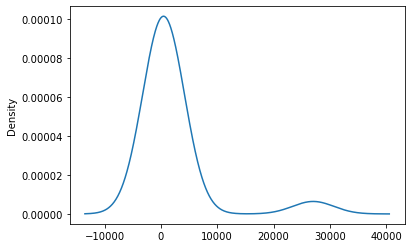

In [6]:
# Visualize the value counts of APPLICATION_TYPE
app_type.plot.density()

In [7]:
# Determine which values to replace if counts are less than ...?
replace_application = list(app_type[app_type < 500].index)

# Replace in dataframe
for app in replace_application:
    application_df.APPLICATION_TYPE = application_df.APPLICATION_TYPE.replace(app,"Other")
    
# Check to make sure binning was successful
application_df.APPLICATION_TYPE.value_counts()

T3       27037
T4        1542
T6        1216
T5        1173
T19       1065
T8         737
T7         725
T10        528
Other      276
Name: APPLICATION_TYPE, dtype: int64

In [8]:
# Look at CLASSIFICATION value counts for binning
classification_type = application_df.CLASSIFICATION.value_counts()
classification_type

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
         ...  
C4120        1
C8210        1
C2561        1
C4500        1
C2150        1
Name: CLASSIFICATION, Length: 71, dtype: int64

<AxesSubplot:ylabel='Density'>

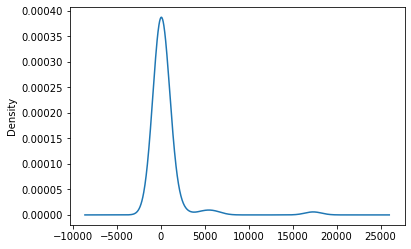

In [9]:
# Visualize the value counts of CLASSIFICATION
classification_type.plot.density()

In [10]:
# Determine which values to replace if counts are less than ..?
replace_class = list(classification_type[classification_type < 1800].index)

# Replace in dataframe
for cls in replace_class:
    application_df.CLASSIFICATION = application_df.CLASSIFICATION.replace(cls,"Other")
    
# Check to make sure binning was successful
application_df.CLASSIFICATION.value_counts()

C1000    17326
C2000     6074
C1200     4837
Other     2261
C3000     1918
C2100     1883
Name: CLASSIFICATION, dtype: int64

## Optimization 1
### Both AFFILIATION and USE_CASE columns have very low counts in Other category
#### These columns will be dropped in the scaled data to reduce noise

In [11]:
# Check optimization_df for values in AFFILIATION column
affiliation = optimization_df.AFFILIATION.value_counts()
affiliation

Independent         18480
CompanySponsored    15705
Family/Parent          64
National               33
Regional               13
Other                   4
Name: AFFILIATION, dtype: int64

In [12]:
# Check optimization_df for values in USE_CASE column
use_Case = optimization_df.USE_CASE.value_counts()
use_Case

Preservation     28095
ProductDev        5671
CommunityServ      384
Heathcare          146
Other                3
Name: USE_CASE, dtype: int64

### Dropping AFFILIATION_Other and USE_CASE_Other showed no improvements in accuracy

#### Additional optimization will follow below. Model names  and saved weight checkpoints are updated to reflect steps taken

In [13]:
# Generate our categorical variable lists
application_cat = application_df.dtypes[application_df.dtypes == "object"].index.tolist()

In [14]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(application_df[application_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(application_cat)
encode_df.head()

C:\Users\merri\anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,APPLICATION_TYPE_T8,AFFILIATION_CompanySponsored,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [15]:
# Merge one-hot encoded features and drop the originals
application_df = application_df.merge(encode_df, left_index=True, right_index=True)
application_df = application_df.drop(application_cat, 1)
application_df.head()

C:\Users\merri\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


,STATUS,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,1,5000,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,108590,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,5000,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,6692,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,142590,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [16]:
# Split our preprocessed data into our features and target arrays
y = application_df["IS_SUCCESSFUL"].values
X = application_df.drop(["IS_SUCCESSFUL"],1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=78)

C:\Users\merri\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

C:\Users\merri\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.


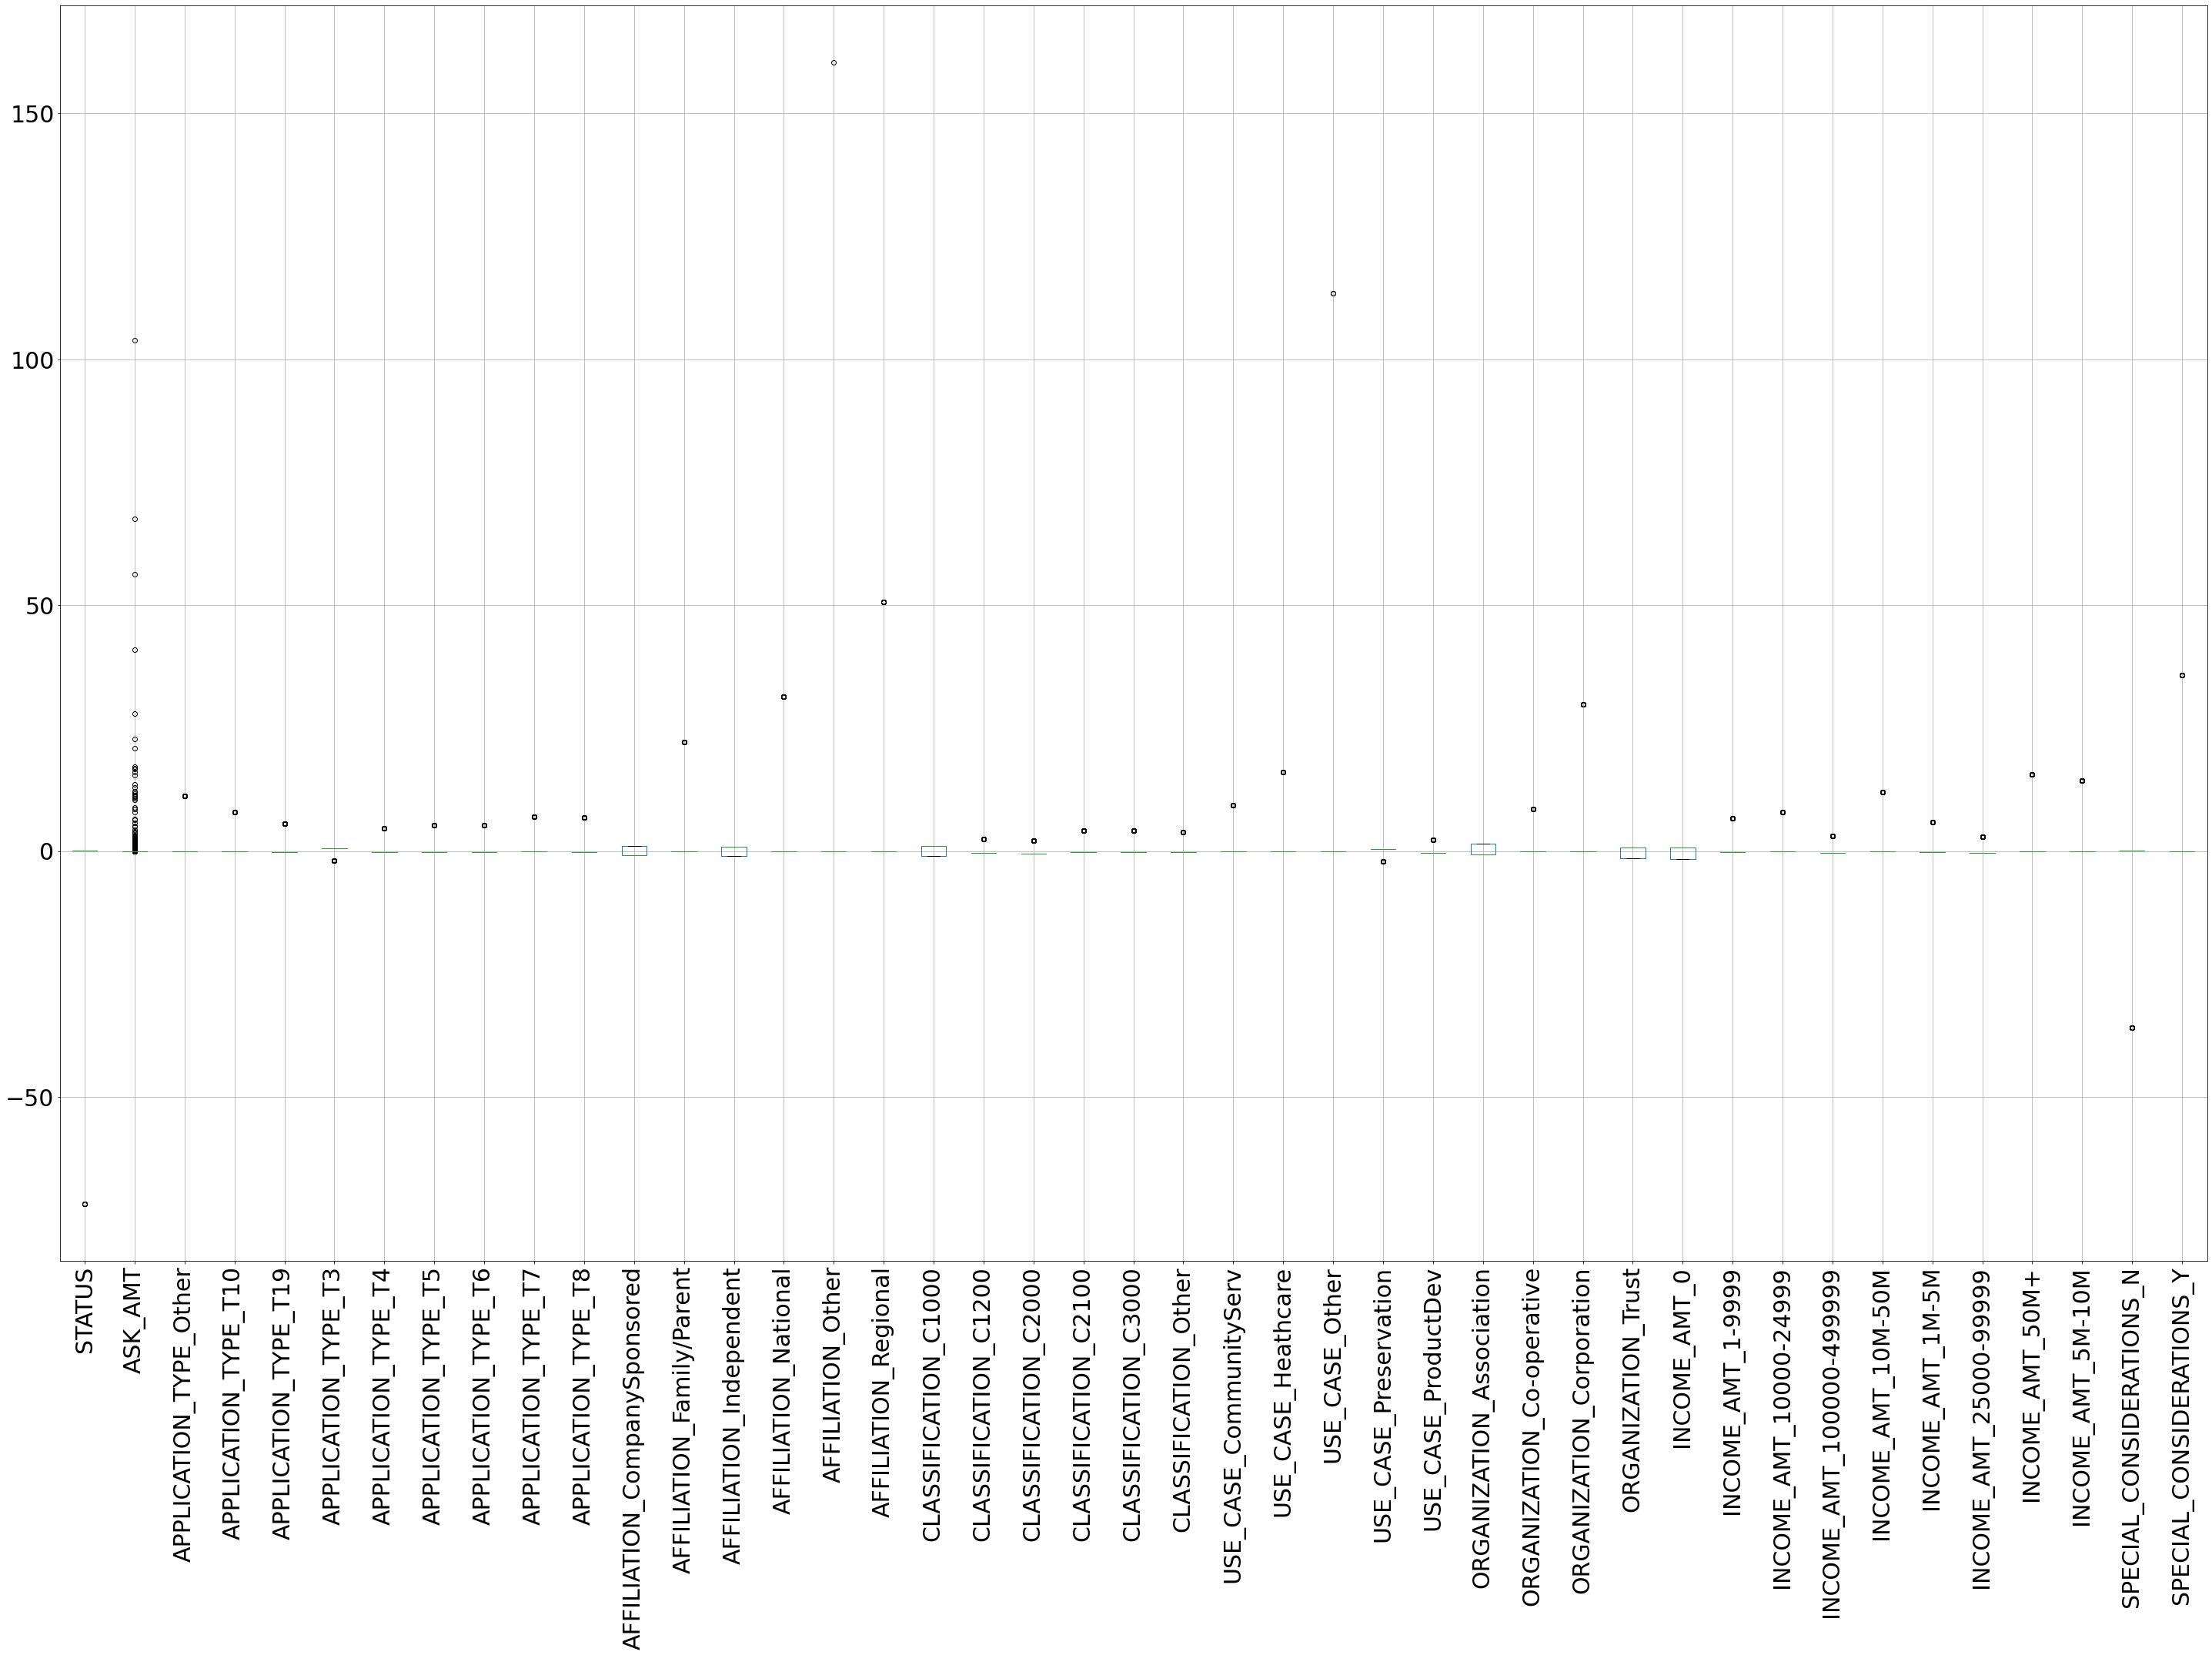

In [18]:
# Create boxplot to determine if any outliers in the application dataset are reducing model's learning accuracy

# copy application_df DataFrame with target column IS_SUCCESSFUL dropped
columns_df = application_df.drop(["IS_SUCCESSFUL"],1)
# Save column names to columns variable
columns = columns_df.columns
# Save scaled training features data to DataFrame and rename columns from saved columns variable
check_outliers_df = pd.DataFrame(X_train_scaled, columns=columns)
# plot the scaled data
boxplot = check_outliers_df.boxplot(figsize=(50, 30), rot=90, fontsize=30)

### Note: after Optimizations 1 and 2, STATUS column has been dropped as neither feature nor target

### Note: after keras_tuner showed only minimal improvement in accuracy SPECIAL_CONSIDERATIONS_N column removed to further reduce noise in dataset

#### SPECIAL_CONSIDERATIONS_N does not offer new unique information with SPECIAL_CONSIDERATIONS_Y column available

In [19]:
# Split our preprocessed data into our features and target arrays
y = application_df["IS_SUCCESSFUL"].values

X = application_df.drop(["IS_SUCCESSFUL", "AFFILIATION_Other", "USE_CASE_Other", "STATUS", "SPECIAL_CONSIDERATIONS_N"],1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=78)

C:\Users\merri\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.


## Optimization 7
### utilize the features of RobustScaler instead of StandardScaler
### RobustScaler is robust to outliers, and may result in more manageable data for the learning model.

In [ ]:
# Create a RobustScaler instance
robust = RobustScaler()
X_robust = robust.fit(X_train)
X_train_robust = X_robust.transform(X_train)
X_test_robust = X_robust.transform(X_test)

In [20]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Optimization 2
### Additional hidden layer created with 20 nodes
#### Optimization 2 provided minimal improvements to accuracy

## Optimization 6
### increase number of nodes in first hidden layer to 100
### first hidden layer activation = "RELU", second and third hidden layer activation = "SIGMOID"
#### test outside kerastuner to reduce processing time

In [21]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train[0])
# increase nodes of first hidden layer to 100 in optimization attempt 6
hidden_nodes_layer1 = 100
hidden_nodes_layer2 = 30
hidden_nodes_layer3 = 20

nn_optimization6 = tf.keras.models.Sequential()

# First hidden layer
nn_optimization6.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

# Second hidden layer
nn_optimization6.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="sigmoid"))

# Third hidden layer
nn_optimization6.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="sigmoid"))

# Output layer
nn_optimization6.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn_optimization6.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               4000      
                                                                 
 dense_1 (Dense)             (None, 30)                3030      
                                                                 
 dense_2 (Dense)             (None, 20)                620       
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 7,671
Trainable params: 7,671
Non-trainable params: 0
_________________________________________________________________


## Create the model to utilize RobustScaler data

In [21]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train[0])
# increase nodes of first hidden layer to 100 in optimization attempt 6
hidden_nodes_layer1 = 100
hidden_nodes_layer2 = 30
hidden_nodes_layer3 = 20

nn_robust = tf.keras.models.Sequential()

# First hidden layer
nn_robust.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

# Second hidden layer
nn_robust.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="sigmoid"))

# Third hidden layer
nn_robust.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="sigmoid"))

# Output layer
nn_robust.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn_robust.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               4000      
                                                                 
 dense_1 (Dense)             (None, 30)                3030      
                                                                 
 dense_2 (Dense)             (None, 20)                620       
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 7,671
Trainable params: 7,671
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Define the checkpoint path and filenames
os.makedirs("checkpoints/optimization7robust",exist_ok=True)
checkpoint_path = "checkpoints/optimization7robust/weights.{epoch:02d}.hdf5"

# Create callback to save the model every 5 epochs
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=5)

In [ ]:
# Compile the model
nn_robust.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
# Fit the model
fit_model = nn_robust.fit(X_train_robust, y_train, epochs=100)

In [ ]:
# Check model accuracy and loss
model_loss, model_accuracy = nn_robust.evaluate(X_test_robust,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

In [23]:
# Compile the model
nn_optimization6.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [24]:
fit_model = nn_optimization6.fit(X_train_scaled, y_train, epochs=100)

Epoch 1/100
804/804 [==============================] - 3s 2ms/step - loss: 0.5813 - accuracy: 0.7155
Epoch 2/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5575 - accuracy: 0.7303
Epoch 3/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5538 - accuracy: 0.7314
Epoch 4/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5526 - accuracy: 0.7317
Epoch 5/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5511 - accuracy: 0.7321
Epoch 6/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5500 - accuracy: 0.7336
Epoch 7/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5490 - accuracy: 0.7344
Epoch 8/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5480 - accuracy: 0.7341
Epoch 9/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5475 - accuracy: 0.7350
Epoch 10/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5467 - accura

In [25]:
model_loss, model_accuracy = nn_optimization6.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 1s - loss: 0.5551 - accuracy: 0.7262 - 505ms/epoch - 2ms/step
Loss: 0.5550602078437805, Accuracy: 0.7261807322502136


## Optimization 3
### Function created to create Sequential model with hyperparameter options
### And utilize kerastuner to determine best model hyperparameters

## Optimization 4

### Reduced max_value in kerastuner layer units to prevent opportunity for overfitting the model

## Optimization 5
### Increase max_value of nodes per layer to 100
### Increase maximum tuner epochs to 100
### Increase range of potential hidden layers for kerastuner to max 10

## Optimization 7
### Increase max_value of nodes to 100, max_value of layers to 10, max_epochs to 100
### utilize a RobustScaler data scaler to reduce the impact of outliers in the dataset

In [26]:
# Create function
def create_model3(hp):
    nn_model = tf.keras.models.Sequential()
    
    # Kerastuner to determine activation function to use in hidden layers
    activation = hp.Choice('activation', ['relu', 'sigmoid','softmax','softplus','softsign','tanh','selu','elu','exponential'])
    number_input_features = len(X_train[0])
    
    # Note: first attempt with kerastuner used max_value of nodes = 60
    # Kerastuner to determine number of neurons in first layer
    nn_model.add(
        tf.keras.layers.Dense(units=hp.Int('first_units',
                                          min_value=1,
                                          max_value=100,
                                          step=2), activation=activation, input_dim=number_input_features))
    
    # Note: first attempt with kerastuner used max_value of nodes = 60
    # Kerastuner to determine number of hidden layers and nodes in hidden layer
    for i in range(hp.Int('num_layers', 1, 10)):
        nn_model.add(
            tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
                                              min_value=1,
                                              max_value=100,
                                              step=2),
                                                activation=activation))
        
        
        
        # output layer
        nn_model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
        
        # Set optimizer variable to allow kerastuner to determine optimal optimizer
        opt = hp.Choice('optimizer_',[
                        'SGD',
                        'RMSprop',
                        'Adam',
                        'Adadelta',
                        'Adagrad',
                        'Adamax',
                        'Nadam',
                        'Ftrl'])
        
        # Compile the model
        nn_model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
        
        
        return nn_model

In [27]:
# import kerastuner library
import kerastuner as kt
tuner3 = kt.Hyperband(
    create_model3,
    objective='val_accuracy',
    max_epochs=100,
    hyperband_iterations=4)

C:\Users\merri\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  


In [28]:
# Define the checkpoint path and filenames
os.makedirs("checkpoints/optimization5",exist_ok=True)
checkpoint_path = "checkpoints/optimization5/weights.{epoch:02d}.hdf5"

# Create callback to save the model every 5 epochs
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=5)

In [29]:
# Run kerastuner to search for best hyperparameters
tuner3.search(X_train_scaled, y_train, epochs=100, validation_data=(X_test_scaled, y_test), callbacks=[cp_callback])

Trial 1016 Complete [00h 08m 15s]
val_accuracy: 0.7272303104400635

Best val_accuracy So Far: 0.72967928647995
Total elapsed time: 17h 11m 15s
INFO:tensorflow:Oracle triggered exit


In [30]:
# Get best model hyperparameters
best_hyper3 = tuner3.get_best_hyperparameters(1)[0]
best_hyper3.values

{'activation': 'tanh',
 'first_units': 93,
 'num_layers': 9,
 'units_0': 83,
 'optimizer_': 'Adamax',
 'tuner/epochs': 100,
 'tuner/initial_epoch': 34,
 'tuner/bracket': 2,
 'tuner/round': 2,
 'tuner/trial_id': '0991'}

In [31]:
# Evaluate the model using the test data
best_model3 = tuner3.get_best_models(1)[0]
model_loss, model_accuracy = best_model3.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 1s - loss: 0.5519 - accuracy: 0.7297 - 732ms/epoch - 3ms/step
Loss: 0.5519450902938843, Accuracy: 0.72967928647995


In [33]:
# Export model to HDF5 file
best_model3.save("trained_application3.h5")